# Concepts

## Mapper - Read file
For each Text we create a set of k-shingles
we need to pic the k carefulls so any given shingle is unique and we don't have too many shingles k=5 seems to be a good choice

## Mapper - make shingle-sets
We hash the shingles to reduce data size and to make the comparison of the shingles easier


---
##### What if all shingle sets don't fit into main memory and we cannot make a universal-set?
---

*In map reduce we don't need to make a universal-set and calculate Bit-Vectors because we use Min-Hashing to approximate the Jaccard-Distance of two Sets ,this works because if a Hash function can put each shingle into a bucket and we have as many or more buckets then Shingles in the master set, then the hash function simulates the master set and because we use the min() property this is the same as permuting the characteristic Matrix*

Hierzu hilft es sich vorzustellen, dass jeder bucket der minhash funktion einer Zeile der Charakteristischen Matrix entspricht, und durch die min() eigenschaft wir dann quasi eine Permutation auf allen Spalten gleichzeitig machen, da gleiche Elemente den gleichen Hashwert haben und somit in den gleichen Bucket kommen, wir ignorieren hier, dass wir auch hash-kollisionen haben können, da wir eine sehr große anzahl an buckets haben und die wahrscheinlichkeit für eine kollision sehr gering ist, oder im Zweifel zu einem Falsch positiven führt, was nicht schlimm ist, da wir ja nur eine Approximation der Jaccard-Distanz wollen.

## Mapper - calculate the MinHash-Signature for shingle set
We don't need to calculate the Characteristic Matrix because we use Min-Hashing to approximate the Jaccard-Distance of two Sets we just need to find the right bucket-size therfore approximate the maximum number of shingles(or use a very large prime number ?)


## Mapper - calculate the LSH-Bucket-number (key= bucket_number, value=doc_id)
We use b Bands with size #hash_functions / b and hash each band to a bucket -> we get the following key-value pairs for the reducer (key= bucket_number, value=doc_id)

## Reducer - find candidate pairs
Since the reducer gets a list of doc_id´s that got hased into the same bucket each reducer can directly emit (yield) all possible pairs of doc_id´s that got hashed into the same bucket and we have the desired output (doc_id1, doc_id2) of a potential pair of similar documents

# Load Data
 * Zuerst laden wir die Daten (Die beiden Texte aus der Eingabedatei)
 * Jeder Text wird einzeln betrachtet und in einer Liste gespeichert

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# create a list of all the texts
texts = []
with open('subset.txt', 'r') as f:
    for line in f:
        elements = line.strip().split('\t')
        texts.append(elements[0].replace('\n', ''))
        texts.append(elements[1])

In [15]:
for i in range(0, 5):
    print(texts[i])

Turn off the main breaker.
Hot or not? Now turn the main on, and B2 off.
I think it would.
I don't think you should.
You don't need any visa.


# Erstellen der Shingles für jeden Text
 * Im ersten Map Schritt erstellen wir für jeden Text eine Liste von Shingles
 * Als key können wir die Texte verwenden, da wir diese später wieder brauchen
 * Der Value ist eine Liste von Shingles

In [16]:
shingles_per_text = []
k = 3
for text in texts:
    shingles_per_text.append(set([text[i:i + k] for i in range(len(text) - k + 1)]))

# Create Bit-Vector for each text (Matrix of Bit-Vectors [f. 51])

In [17]:
# create a set of all shingles
all_shingles_of_file = set()
for shingle_of_text in shingles_per_text:
    all_shingles_of_file.update(shingle_of_text)

In [18]:
# create Bit-Vector for each text -> this will yield the matrix of the bit-vectors
bit_Matrix = []
for shingle_of_text in shingles_per_text:
    bit_vector_for_text = []
    
    for shingle_of_file in all_shingles_of_file:
        
        if shingle_of_file in shingle_of_text:
            bit_vector_for_text.append(1)
        else:
            bit_vector_for_text.append(0)
            
    bit_Matrix.append(bit_vector_for_text)

In [19]:
# nur um zz zeigen, dass es funktioniert
for i in range(0, 5):
    print(bit_Matrix[i][0:8])

[0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]


# Calculate MinHash-Signature for each text

# Create Hash-Functions (random permutations)

In [20]:
# generate n hash functions (random permutations)
n = 500
hash_functions = []
for h in range(n):
    perm = np.random.permutation(len(all_shingles_of_file))
    hash_functions.append(perm)

# Calculate MinHash-Signature for each text (MinHash Matrix)

In [21]:
signature_matrix = []
for bit_vector in bit_Matrix:
    signature_vector = []
    for hash_function in hash_functions:
        # find the first 1 in the bit vector
        # we don't permutate the original bit vector, we instead use the hash function and check the bit vector at the permutated index
        for col_index in range(len(bit_vector)):
            if bit_vector[hash_function[col_index]] == 1:
                signature_vector.append(hash_function[col_index])
                break
    signature_matrix.append(signature_vector)

In [22]:
for i in range(0, 5):
    print(signature_matrix[i][0:8])

[76, 168, 340, 77, 77, 263, 103, 274]
[146, 198, 363, 77, 77, 146, 12, 366]
[4, 355, 355, 152, 55, 55, 359, 293]
[4, 166, 334, 165, 335, 165, 371, 104]
[252, 226, 200, 165, 219, 165, 219, 104]


### Compare the MinHash-Signatures similarity to the Jaccard-Similarity

In [23]:
def find_similarities(index=0):
    sig_1 = signature_matrix[index]
    bit_v_1 = bit_Matrix[index]
    sig_sims = []
    bit_sims = []
    
    for col in signature_matrix:
        sig_sims.append(np.sum(np.array(sig_1) == np.array(col)) / len(signature_matrix[0]))
    
    for col in bit_Matrix:
        intersection = np.sum(np.array(bit_v_1) & np.array(col))
        union = np.sum(np.array(bit_v_1) | np.array(col))
        bit_sims.append(intersection / union)
        
    
    return pd.DataFrame({'Jaccard-Similarity': bit_sims, 'MinHash-Similarity': sig_sims, 'Text': texts, 'difference': np.array(sig_sims) - np.array(bit_sims)})

In [24]:
similarities = find_similarities(index=2)
similarities

,Jaccard-Similarity,MinHash-Similarity,Text,difference
0,0.026316,0.040,Turn off the main breaker.,0.013684
1,0.017544,0.026,"Hot or not? Now turn the main on, and B2 off.",0.008456
2,1.000000,1.000,I think it would.,0.000000
3,0.266667,0.294,I don't think you should.,0.027333
4,0.000000,0.000,You don't need any visa.,0.000000
5,0.000000,0.000,You don't need sauce at all.,0.000000
6,0.000000,0.000,You don't have to know.,0.000000
7,0.000000,0.000,"""I don't have to tell you.""""""",0.000000
8,0.014706,0.018,"And if you're holding in a Roth IRA, you get t...",0.003294
9,0.052632,0.040,Consider the tax bracket that you would be in ...,-0.012632


# find possible pairs of similar texts with LSH 

# Create Bands and set Hyperparameters

# sort bands into buckets

In [25]:
def lsh_hash_function(band, num_buckets):
    # Convert the band (which could be a list or tuple) to a string representation
    # since the built-in hash function requires a single immutable argument.
    string_band = str(band)

    # Use the built-in hash function and take the modulo of the number of buckets
    return hash(string_band) % num_buckets

In [26]:
def sort_bands_into_buckets(number_of_buckets=10000000, number_bands=64, number_rows_per_band=len(hash_functions) / 64):
    buckets = dict()
    for col_index in range(len(signature_matrix)):
        for band_num in range(number_bands):
            # get the signature vector for the current text
            signature_vector = signature_matrix[col_index]
            # get the current band
            start_index = int(band_num * number_rows_per_band)
            end_index = int((band_num + 1) * number_rows_per_band)
            band = signature_vector[start_index:end_index]
            # calculate the hash value for the band
            bucket_index = lsh_hash_function(band, number_of_buckets)
            # add the text to the bucket
            buckets[bucket_index] = buckets.get(bucket_index, []) + [col_index]
            
    return buckets
        

# find candidate pairs

In [27]:
def find_candidate_pairs(buckets):    
    candidate_pairs = set()
    for bucket in buckets.values():
        for i in range(len(bucket)):
            for j in range(i + 1, len(bucket)):
                candidate_pairs.add((bucket[i], bucket[j]))
    return candidate_pairs

# compare number of candidate pairs for hyperparameters n_bands and n_buckets

In [28]:
number_bands = [2, 4, 8, 16, 32, 64]
number_rows_per_band = [len(hash_functions) / number_bands for number_bands in number_bands]
number_of_buckets = [10000000, 100000000]

# plot number of candidate pairs for number of bands going from 2 to 32 and number of buckets going from 100 to 10000000
for n_bands in number_bands:
    for n_buckets in number_of_buckets:
        buckets = sort_bands_into_buckets(n_buckets, n_bands, len(hash_functions) / n_bands)
        candidate_pairs = find_candidate_pairs(buckets)
        print(f'Number of candidate pairs for {n_bands} bands and {n_buckets} buckets: {len(candidate_pairs)}')


Number of candidate pairs for 2 bands and 10000000 buckets: 0
Number of candidate pairs for 2 bands and 100000000 buckets: 0
Number of candidate pairs for 4 bands and 10000000 buckets: 0
Number of candidate pairs for 4 bands and 100000000 buckets: 0
Number of candidate pairs for 8 bands and 10000000 buckets: 0
Number of candidate pairs for 8 bands and 100000000 buckets: 0
Number of candidate pairs for 16 bands and 10000000 buckets: 0
Number of candidate pairs for 16 bands and 100000000 buckets: 0
Number of candidate pairs for 32 bands and 10000000 buckets: 0
Number of candidate pairs for 32 bands and 100000000 buckets: 0
Number of candidate pairs for 64 bands and 10000000 buckets: 1
Number of candidate pairs for 64 bands and 100000000 buckets: 1


# get jaccard similarity for candidate pairs (this is extremely slow)

In [29]:
jac_sims = []
candidate_pairs = find_candidate_pairs(sort_bands_into_buckets())
for pair in candidate_pairs:
    jac_sims.append(np.sum(np.array(bit_Matrix[pair[0]]) & np.array(bit_Matrix[pair[1]])) / np.sum(np.array(bit_Matrix[pair[0]]) | np.array(bit_Matrix[pair[1]])))

### create dataframe with jaccard similarities and text pairs

In [30]:
candidate_pairs_df = pd.DataFrame({'Jaccard-Similarity': jac_sims, 'id1': [pair[0] for pair in candidate_pairs], 'Text 1': [texts[pair[0]] for pair in candidate_pairs], 'id2': [pair[1] for pair in candidate_pairs], 'Text 2': [texts[pair[1]] for pair in candidate_pairs]})

In [31]:
# filter all cells, where id1 == id2
candidate_pairs_df = candidate_pairs_df[candidate_pairs_df['id1'] != candidate_pairs_df['id2']]
print(f'Number of possible pairs: {len(texts) * (len(texts) - 1)}')
print(f'Number of found equals (sim=1): {len(candidate_pairs_df[candidate_pairs_df["Jaccard-Similarity"] == 1])}')

# remove jac_sims == 1
candidate_pairs_df = candidate_pairs_df[candidate_pairs_df['Jaccard-Similarity'] != 1]

print(f'Number of not equal candidate pairs: {len(candidate_pairs_df)}')

Number of possible pairs: 380
Number of found equals (sim=1): 0
Number of not equal candidate pairs: 1


In [32]:
candidate_pairs_df

,Jaccard-Similarity,id1,Text 1,id2,Text 2
0,0.371429,6,You don't have to know.,7,"""I don't have to tell you."""""""


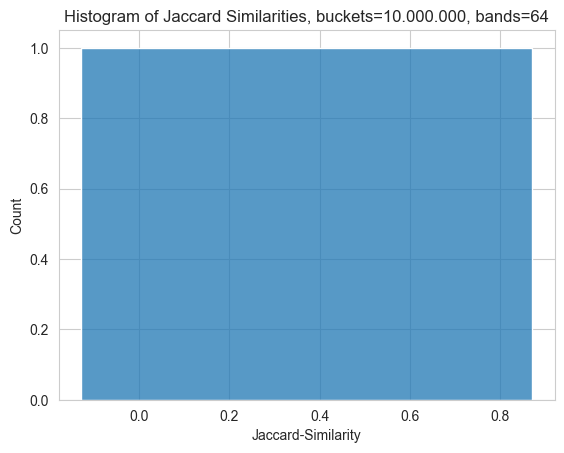

In [33]:
sns.histplot(candidate_pairs_df['Jaccard-Similarity'])
plt.title('Histogram of Jaccard Similarities, buckets=10.000.000, bands=64')
plt.show()